In [1]:
import numpy as np
import pandas as pd

import urllib3 as url
import requests as r
import bs4 as soup
import lxml as html
import json

from xgboost import XGBRegressor, XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Steam WebAPI key
key = "CCEDDDA60CADEE62F99772F47AA8B37C"

#Steam ID
sid = "76561198002994827"
suule = "76561197967021911"

#Cookie
birthtime = {'birthtime': '661388401', 'mature_content': '1'}

#Steam Store
steam = "https://store.steampowered.com/app/"

#Steam Kategorije
sgenres = ["Action","Adventure","Casual","Early Access","Free to Play","Indie","Massively Multiplayer","Racing","RPG","Simulation","Sport","Strategy"]

#Izvor
game_list = "http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key="+key+"&steamid="+sid+"&include_appinfo=1&format=json"

data = pd.read_json(game_list,typ="series")

In [3]:
#Pretvorba Json objekta u DataFrame
inj = json.dumps(data.values[0])
inj = inj[inj.find("["):-1]

out = json.loads(inj)

df = pd.io.json.json_normalize(out)
df = df.drop(["img_icon_url","img_logo_url","has_community_visible_stats","playtime_linux_forever","playtime_mac_forever","playtime_windows_forever"],axis=1)
df.head()

,appid,name,playtime_2weeks,playtime_forever
0,240,Counter-Strike: Source,NaN,1
1,300,Day of Defeat: Source,NaN,0
2,320,Half-Life 2: Deathmatch,NaN,55
3,340,Half-Life 2: Lost Coast,NaN,0
4,70,Half-Life,NaN,14


In [4]:
#Funkcija koja kupi ktegorije sa Steam Store-a
def get_genre(appid):
    genre = []
    game_page = r.get(steam+str(appid),cookies = birthtime)
    parsed_page = soup.BeautifulSoup(game_page.content,"lxml")
    details_block = parsed_page.find("div", class_= "block_content_inner")
    if details_block == None:
        genre = "NaN"
    else:
        for row in details_block.find_all("div", class_="dev_row"):
            row.decompose()
        for row in details_block.find_all("a", class_="linkbar"):
            row.decompose()
        for a in details_block.find_all("a"):
            genre.append(a.get_text())
        if not genre:
            genre = "NaN"
    return genre

In [5]:
#Funkcija koja razdvaja listu žanrova u "genre" stupcu u pojedinačne stupce
def populate(dataframe,list_,column):
    newdf = dataframe
    for item in list_:
        lis = []
        for row in newdf[column]:
            if item in row:
                lis.append(1)
            else:
                lis.append(0)
        newdf[item] = lis
    newdf = newdf.drop([column],axis=1)
    newdf.columns = map(str.lower, newdf.columns)
    return newdf

In [6]:
#Funkcija za jednostavno razdvajane 
def binary(dataframe,column,newcol):
    newdf = dataframe
    lis = []
    for row in newdf[column]:
        if row == 0:
            lis.append(0)
        else:
            lis.append(1)
    newdf[newcol] = lis
    return newdf

In [7]:
df["genre"] = df["appid"].apply(get_genre)
df["playtime_2weeks"] = df["playtime_2weeks"].fillna(0).astype("int64")

In [8]:
#pd.set_option('display.max_rows', None)
df.head(10)

,appid,name,playtime_2weeks,playtime_forever,genre
0,240,Counter-Strike: Source,0,1,[Action]
1,300,Day of Defeat: Source,0,0,[Action]
2,320,Half-Life 2: Deathmatch,0,55,[Action]
3,340,Half-Life 2: Lost Coast,0,0,[Action]
4,70,Half-Life,0,14,[Action]
5,2400,The Ship,0,15,"[Action, Indie, RPG]"
6,2420,The Ship Single Player,0,0,"[Action, Indie, RPG]"
7,2430,The Ship Tutorial,0,160,NaN
8,2100,Dark Messiah of Might & Magic Single Player,0,169,"[Action, RPG]"
9,2130,Dark Messiah of Might & Magic Multi-Player,0,0,"[Action, RPG]"


In [9]:
# oblikovanje konačane baze koja će se koristiti za testiraje
dff = populate(df,sgenres,"genre")
dff = binary(dff,"playtime_2weeks","2weeks")
dff = binary(dff,"playtime_forever","4ever")

In [10]:
dff.head(10)

,appid,name,playtime_2weeks,playtime_forever,action,adventure,casual,early access,free to play,indie,massively multiplayer,racing,rpg,simulation,sport,strategy,2weeks,4ever
0,240,Counter-Strike: Source,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,300,Day of Defeat: Source,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,320,Half-Life 2: Deathmatch,0,55,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,340,Half-Life 2: Lost Coast,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,70,Half-Life,0,14,1,0,0,0,0,0,0,0,0,0,0,0,0,1
5,2400,The Ship,0,15,1,0,0,0,0,1,0,0,1,0,0,0,0,1
6,2420,The Ship Single Player,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
7,2430,The Ship Tutorial,0,160,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,2100,Dark Messiah of Might & Magic Single Player,0,169,1,0,0,0,0,0,0,0,1,0,0,0,0,1
9,2130,Dark Messiah of Might & Magic Multi-Player,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


Text(0.5, 1.0, 'Sveukupno')

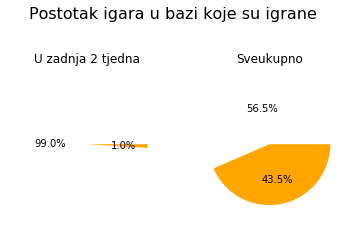

In [11]:
fig, axs = plt.subplots(1, 2)
fig.suptitle("Postotak igara u bazi koje su igrane", fontsize = 16)

axs[0].pie(dff["2weeks"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0].set_title("U zadnja 2 tjedna")
axs[1].pie(dff["4ever"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1].set_title("Sveukupno")

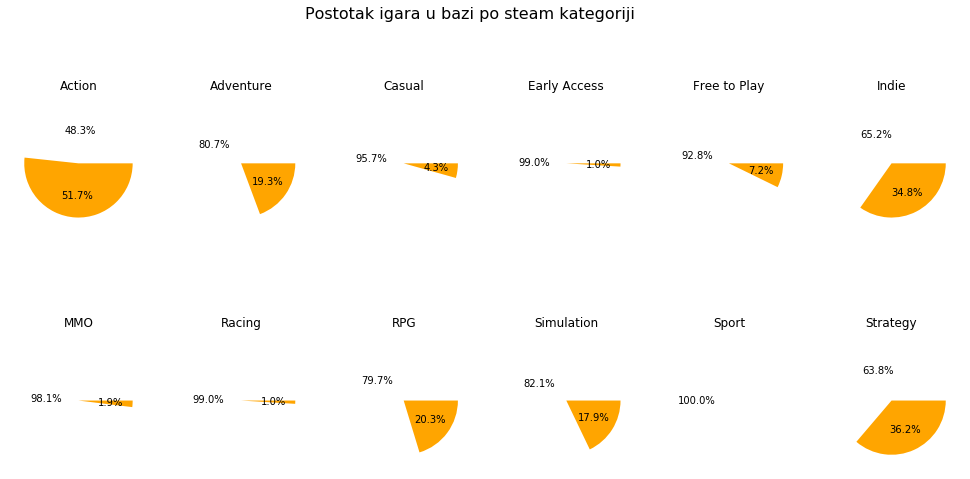

In [12]:
fig, axs = plt.subplots(2, 6)
fig.suptitle("Postotak igara u bazi po steam kategoriji", fontsize = 16)

axs[0, 0].pie(dff["action"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 0].set_title("Action")
axs[0, 1].pie(dff["adventure"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 1].set_title("Adventure")
axs[0, 2].pie(dff["casual"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 2].set_title("Casual")
axs[0, 3].pie(dff["early access"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 3].set_title("Early Access")
axs[0, 4].pie(dff["free to play"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 4].set_title("Free to Play")
axs[0, 5].pie(dff["indie"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 5].set_title("Indie")
axs[1, 0].pie(dff["massively multiplayer"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 0].set_title("MMO")
axs[1, 1].pie(dff["racing"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 1].set_title("Racing")
axs[1, 2].pie(dff["rpg"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 2].set_title("RPG")
axs[1, 3].pie(dff["simulation"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 3].set_title("Simulation")
axs[1, 4].pie(dff["sport"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 4].set_title("Sport")
axs[1, 5].pie(dff["strategy"].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 5].set_title("Strategy")

plt.gcf().set_size_inches(17,8)

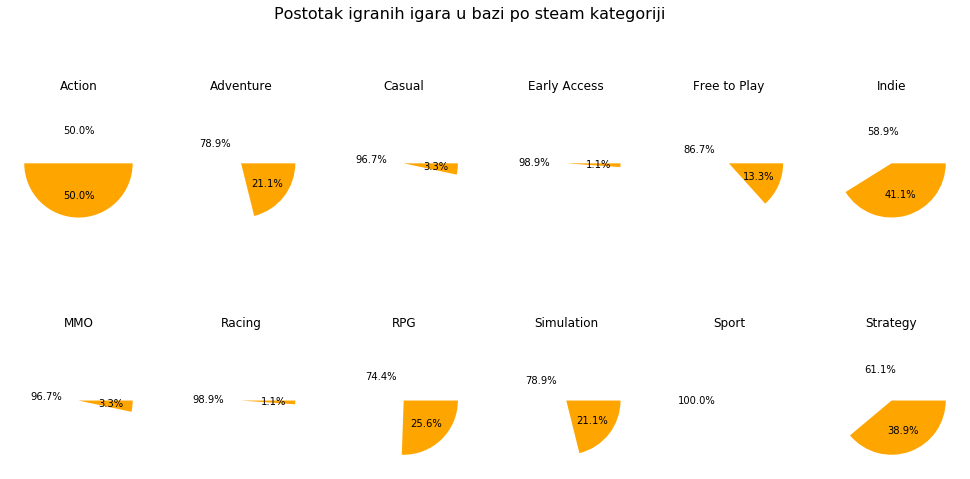

In [13]:
fig, axs = plt.subplots(2, 6)
fig.suptitle("Postotak igranih igara u bazi po steam kategoriji", fontsize = 16)

axs[0, 0].pie(dff["action"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 0].set_title("Action")
axs[0, 1].pie(dff["adventure"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 1].set_title("Adventure")
axs[0, 2].pie(dff["casual"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 2].set_title("Casual")
axs[0, 3].pie(dff["early access"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 3].set_title("Early Access")
axs[0, 4].pie(dff["free to play"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 4].set_title("Free to Play")
axs[0, 5].pie(dff["indie"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[0, 5].set_title("Indie")
axs[1, 0].pie(dff["massively multiplayer"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 0].set_title("MMO")
axs[1, 1].pie(dff["racing"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 1].set_title("Racing")
axs[1, 2].pie(dff["rpg"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 2].set_title("RPG")
axs[1, 3].pie(dff["simulation"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 3].set_title("Simulation")
axs[1, 4].pie(dff["sport"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 4].set_title("Sport")
axs[1, 5].pie(dff["strategy"][dff["4ever"]==1].value_counts(sort=False),colors=["#FFFFFF","orange"],autopct='%1.1f%%')
axs[1, 5].set_title("Strategy")

plt.gcf().set_size_inches(17,8)

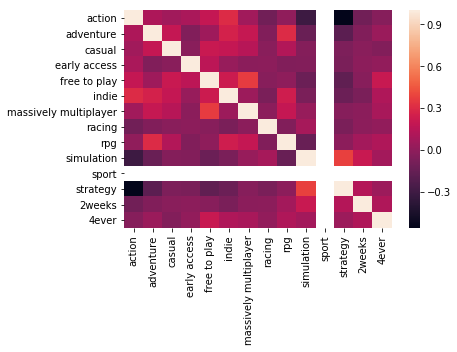

In [14]:
korelacija = dff.drop(["appid","name","playtime_2weeks","playtime_forever"],axis=1)
sns.heatmap(korelacija.corr())

In [15]:
average_playtime = dff["playtime_forever"][dff["playtime_forever"]!=0].median()

In [16]:
X = dff.drop(["appid","name","playtime_2weeks","playtime_forever","2weeks","4ever"],axis=1)
y = dff["4ever"] + dff["2weeks"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

xgbr = XGBClassifier()
xgbr.fit(X_train, y_train)
predikcija = xgbr.predict(X_test)

In [17]:
#Iako točnost nije bajna, poanta je da algoritam predloži igre koje su slične igrama koje je korisnik igrao
count_misclassified = (y_test != predikcija).sum()
accuracy = accuracy_score(y_test, predikcija)

print('Misclassified samples: {}'.format(count_misclassified))
print('Accuracy: {:.2f}'.format(accuracy))
print("Mean Absolute Error: " + str(mean_absolute_error(predikcija, y_test)))

Misclassified samples: 22
Accuracy: 0.58
Mean Absolute Error: 0.4230769230769231


In [18]:
#Dodavanje stupca za prijedloge
df_out = dff
df_out["suggest"] = xgbr.predict(df_out[["action","adventure","casual","early access","free to play","indie","massively multiplayer","racing","rpg","simulation","sport","strategy"]])

df_out["suggest"].value_counts()

0    120
1     87
Name: suggest, dtype: int64

In [19]:
#Pročiščavanje konačne liste
df_out = df_out[df_out["2weeks"] != 1].sort_values(by=["playtime_forever"])
df_out = df_out[["appid","name"]][(df_out["suggest"]==1) & (df_out["playtime_forever"]<average_playtime)]
df_out["genre"] = df["genre"]

In [20]:
#top 10 prijedloga gdje su neigrane igre na vrhu
df_out.head(10)

,appid,name,genre
192,491950,Orwell,"[Adventure, Indie, Simulation]"
81,47400,Stronghold 3,"[Simulation, Strategy]"
80,40980,Stronghold Legends,"[Simulation, Strategy]"
79,40970,Stronghold Crusader HD,"[Simulation, Strategy]"
74,57600,Tropico 3: Absolute Power,"[Simulation, Strategy]"
73,33530,Tropico 2: Pirate Cove,"[Simulation, Strategy]"
72,33520,Tropico,"[Simulation, Strategy]"
71,23490,Tropico 3 - Steam Special Edition,"[Simulation, Strategy]"
66,201480,Serious Sam: The Random Encounter,"[Action, Indie, RPG]"
194,236690,Blood Bowl 2,"[Sports, Strategy]"


In [21]:
#Ako treba ponovno pokrenuti stroj makni iz komentar
#dff = dff.drop("suggest",axis=1)